In [1]:
# global imports
from probe_gen.paths import data

# Projection onto mean line

In [ ]:
import probe_gen.probes as probes

behaviour = "science"
layer = 12

activations_tensor_on, attention_mask_on, labels_tensor_on = probes.load_hf_activations_and_labels_at_layer(f"{behaviour}_llama_3b_5k", layer, verbose=True)
activations_tensor_on = probes.MeanAggregation()(activations_tensor_on, attention_mask_on)

activations_tensor_prompted, attention_mask_prompted, labels_tensor_prompted = probes.load_hf_activations_and_labels_at_layer(f"{behaviour}_5k_ministal_8b_5k", layer, verbose=True)
activations_tensor_prompted = probes.MeanAggregation()(activations_tensor_prompted, attention_mask_prompted)

activations_tensor_off, attention_mask_off, labels_tensor_off = probes.load_hf_activations_and_labels_at_layer(f"{behaviour}_llama_3b_prompted_5k", layer, verbose=True)
activations_tensor_off = probes.MeanAggregation()(activations_tensor_off, attention_mask_off)

loaded labels


llama_3b_balanced_5k_layer_12.pkl:   0%|          | 0.00/4.68G [00:00<?, ?B/s]

loaded activations with shape torch.Size([5000, 257, 3072])
calculated attention mask with shape torch.Size([5000, 257])
loaded labels


llama_3b_prompted_balanced_5k_layer_12.p(…):   0%|          | 0.00/4.75G [00:00<?, ?B/s]

loaded activations with shape torch.Size([5000, 257, 3072])
calculated attention mask with shape torch.Size([5000, 257])
loaded labels


qwen_3b_balanced_5k_layer_12.pkl:   0%|          | 0.00/4.69G [00:00<?, ?B/s]

loaded activations with shape torch.Size([5000, 253, 3072])
calculated attention mask with shape torch.Size([5000, 253])


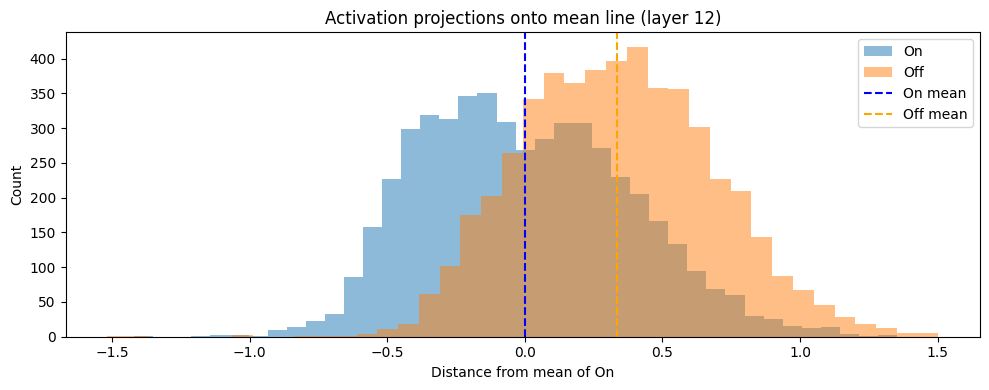

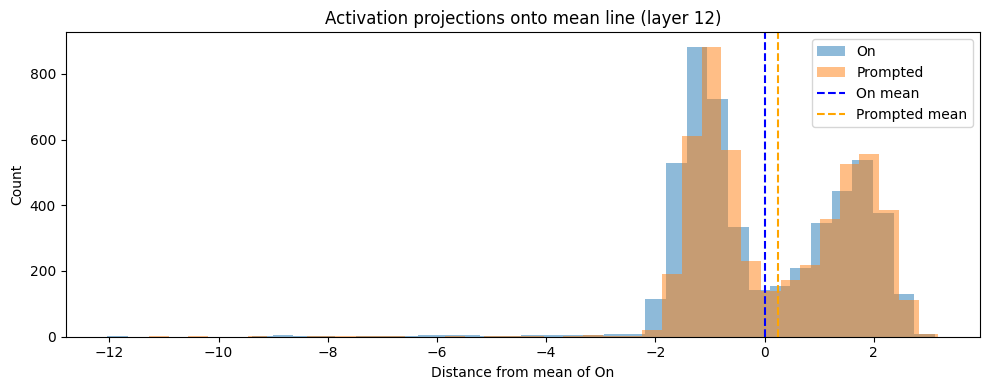

In [5]:
from probe_gen.analysis import plot_activations_mean_line_projections

plot_activations_mean_line_projections(activations_tensor_on, activations_tensor_off, ['On', 'Off'], layer)
plot_activations_mean_line_projections(activations_tensor_on, activations_tensor_prompted, ['On', 'Prompted'], layer)


# PCA

In [ ]:
import probe_gen.probes as probes

behaviour = "science"
layer = 12

activations_tensor_on, attention_mask_on, labels_tensor_on = probes.load_hf_activations_and_labels_at_layer(f"{behaviour}_llama_3b_5k", layer, verbose=True)
activations_tensor_on = probes.MeanAggregation()(activations_tensor_on, attention_mask_on)

activations_tensor_prompted, attention_mask_prompted, labels_tensor_prompted = probes.load_hf_activations_and_labels_at_layer(f"{behaviour}_5k_ministal_8b_5k", layer, verbose=True)
activations_tensor_prompted = probes.MeanAggregation()(activations_tensor_prompted, attention_mask_prompted)

activations_tensor_off, attention_mask_off, labels_tensor_off = probes.load_hf_activations_and_labels_at_layer(f"{behaviour}_llama_3b_prompted_5k", layer, verbose=True)
activations_tensor_off = probes.MeanAggregation()(activations_tensor_off, attention_mask_off)

loaded labels
loaded activations with shape torch.Size([5000, 257, 3072])
calculated attention mask with shape torch.Size([5000, 257])
loaded labels
loaded activations with shape torch.Size([5000, 257, 3072])
calculated attention mask with shape torch.Size([5000, 257])
loaded labels


qwen_3b_balanced_5k_layer_12.pkl:   0%|          | 0.00/4.82G [00:00<?, ?B/s]

loaded activations with shape torch.Size([5000, 253, 3072])
calculated attention mask with shape torch.Size([5000, 253])


/workspace/LASR-probe-gen/src/probe_gen/analysis/activation_analysis.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset1_pca_pos = dataset1_pca[torch.tensor(labels_1, dtype=torch.bool)]
/workspace/LASR-probe-gen/src/probe_gen/analysis/activation_analysis.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset1_pca_neg = dataset1_pca[~torch.tensor(labels_1, dtype=torch.bool)]
/workspace/LASR-probe-gen/src/probe_gen/analysis/activation_analysis.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset2_pca_pos = dataset

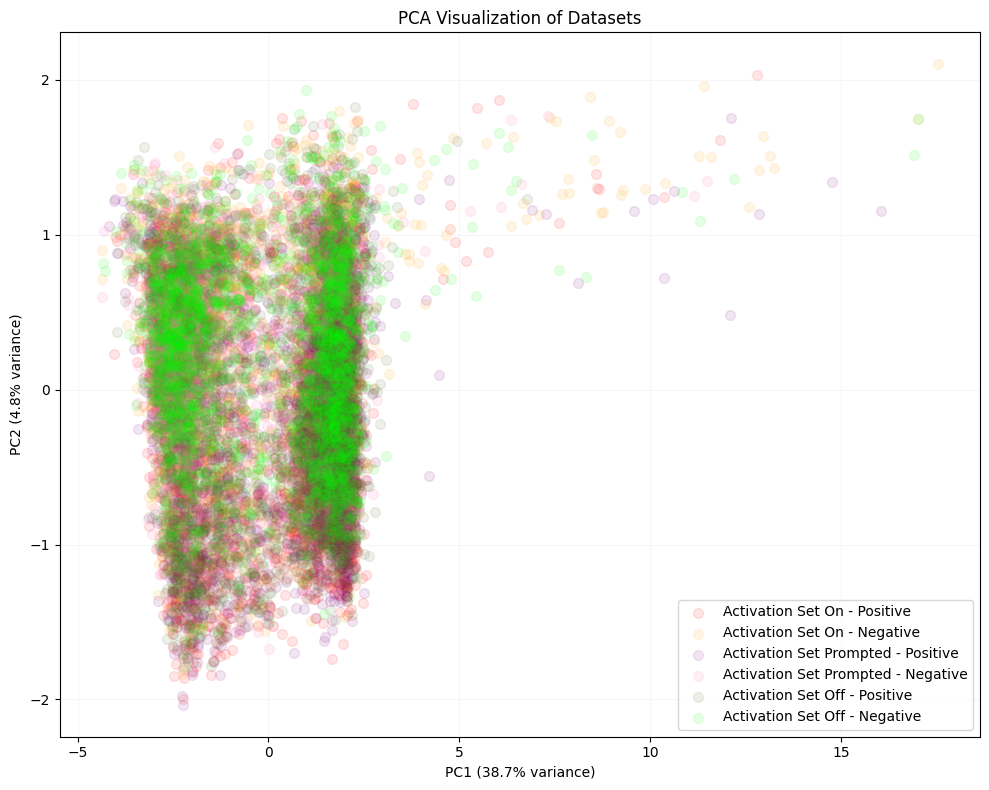

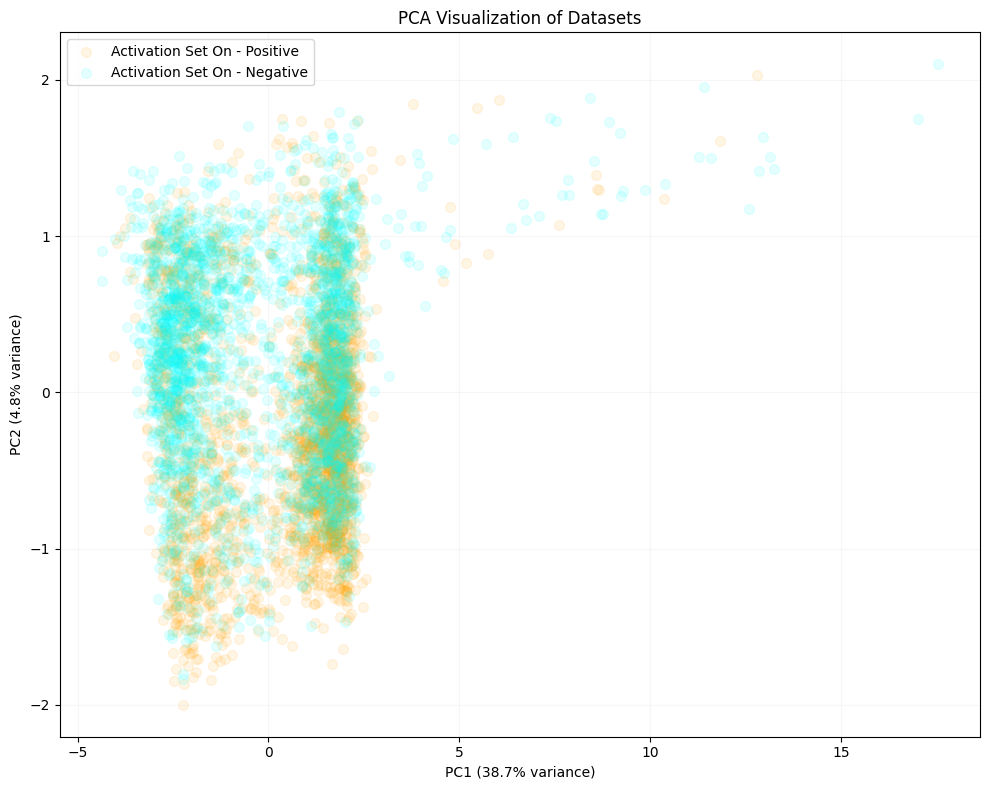

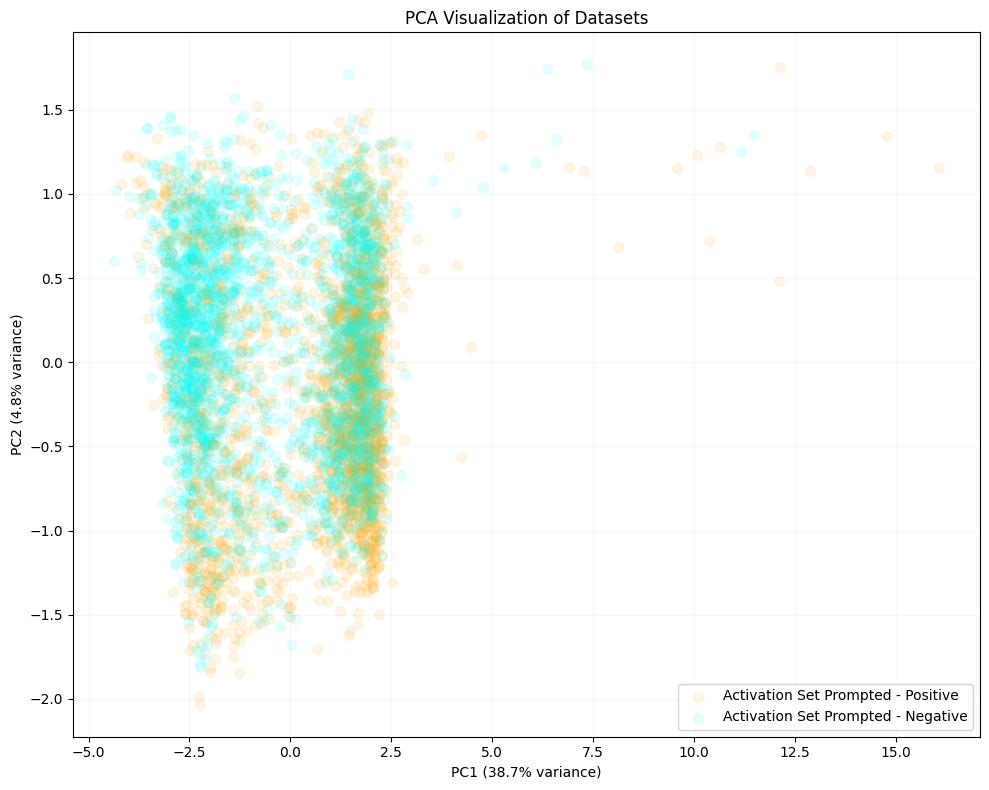

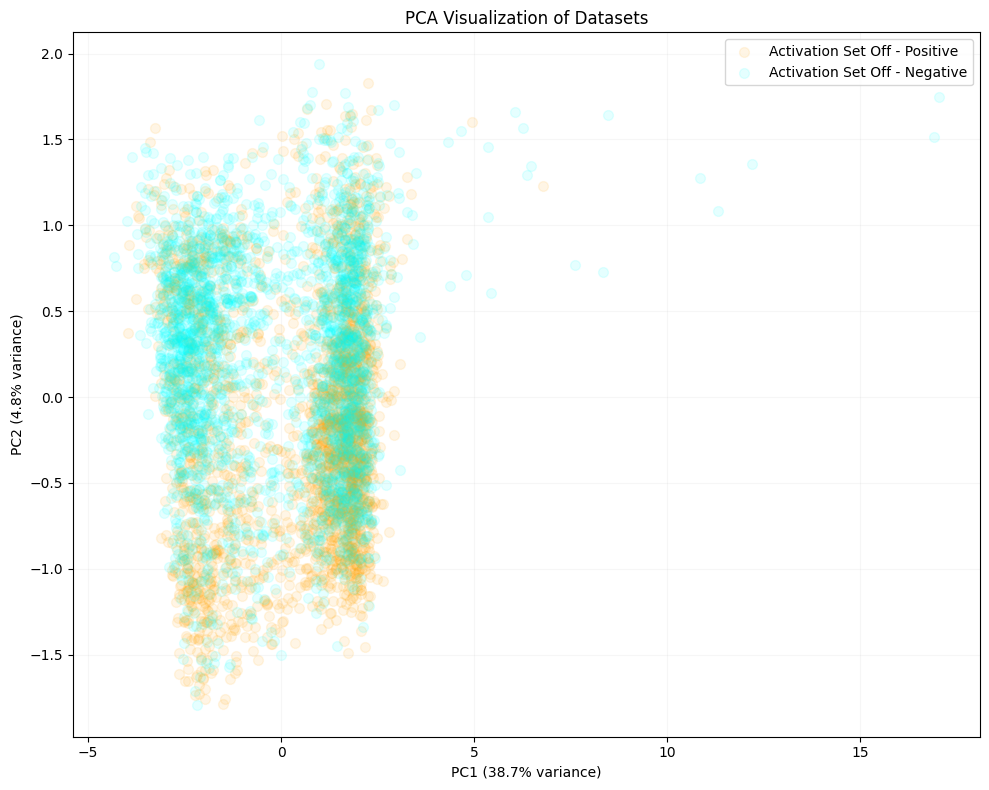

Dataset 1 shape: (5000, 3072)
Dataset 2 shape: (5000, 3072)
Dataset 3 shape: (5000, 3072)
Combined dataset shape: (15000, 3072)
PCA explained variance ratio: [0.3866732  0.04796933]
Total explained variance: 43.5%


In [6]:
from probe_gen.analysis import plot_activations_pca

# 2D visualization (can leave third dataset as None if want)
pca_2d, transformed_2d = plot_activations_pca(
    dataset1=activations_tensor_on,
    dataset2=activations_tensor_prompted,
    dataset3=activations_tensor_off,
    labels_1=labels_tensor_on,
    labels_2=labels_tensor_prompted,
    labels_3=labels_tensor_off,
    n_components=2,
    dataset1_name="Activation Set On", 
    dataset2_name="Activation Set Prompted", 
    dataset3_name="Activation Set Off",
    alpha=0.1
)

In [ ]:
# 3D visualization (can leave third dataset as None if want)
pca_3d, transformed_3d, labels = plot_activations_pca(
    dataset1=activations_tensor_on, 
    dataset2=activations_tensor_off,
    dataset3=activations_tensor_prompted,
    labels_1=labels_tensor_on,
    labels_2=labels_tensor_off,
    labels_3=labels_tensor_prompted,
    n_components=3,
    dataset1_name="Activation Set On", 
    dataset2_name="Activation Set Off",
    dataset3_name="Activation Set Prompted",
    alpha=0.1
)

# Fair PCA

In [ ]:
from probe_gen.gen_data.utils import load_jsonl_data

human_list_on, _, _ = load_jsonl_data(data.refusal / "on_policy_balanced_5k.jsonl")
human_list_off, _, _ = load_jsonl_data(data.refusal / "off_policy_balanced_5k.jsonl")

In [2]:
on_indices = []
off_indices = []
for i in range(len(human_list_on)):
    for j in range(len(human_list_off)):
        if human_list_on[i] == human_list_off[j]:
            on_indices.append(i)
            off_indices.append(j)

In [3]:
import probe_gen.probes as probes

layer = 12

activations_tensor_on, attention_mask_on, labels_tensor_on = probes.load_hf_activations_and_labels_at_layer("refusal_5k_on", layer, verbose=True)
activations_tensor_on = probes.MeanAggregation()(activations_tensor_on, attention_mask_on)

activations_tensor_off, attention_mask_off, labels_tensor_off = probes.load_hf_activations_and_labels_at_layer("refusal_5k_off_other_model", layer, verbose=True)
activations_tensor_off = probes.MeanAggregation()(activations_tensor_off, attention_mask_off)

loaded labels
loaded activations with shape torch.Size([5000, 277, 3072])
calculated attention mask with shape torch.Size([5000, 277])
loaded labels
loaded activations with shape torch.Size([5000, 399, 3072])
calculated attention mask with shape torch.Size([5000, 399])


In [4]:
activations_tensor_on = activations_tensor_on[on_indices]
activations_tensor_off = activations_tensor_off[off_indices]
labels_tensor_on = labels_tensor_on[on_indices]
labels_tensor_off = labels_tensor_off[off_indices]

In [ ]:
from probe_gen.analysis import plot_activations_pca

# 2D visualization
pca_2d, transformed_2d, labels = plot_activations_pca(
    activations_tensor_on, 
    activations_tensor_off, 
    labels_tensor_on,
    labels_tensor_off,
    n_components=2,
    dataset1_name="Activation Set On", 
    dataset2_name="Activation Set Off",
    alpha=0.1
)

# # 3D visualization
# pca_3d, transformed_3d, labels = plot_activations_pca(
#     activations_tensor_on, 
#     activations_tensor_off, 
#     n_components=3,
#     dataset1_name="Activation Set On", 
#     dataset2_name="Activation Set Off",
#     alpha=0.1
# )